In [ ]:
########## 1. Install required packages ##########
!pip install -q transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12

In [ ]:
########## 2. Import required libraries ##########
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, log_loss,roc_auc_score,classification_report, confusion_matrix)
from scipy.special import softmax
from datasets import Dataset
from transformers import (AutoTokenizer, BertConfig, Trainer, TrainingArguments, BertForSequenceClassification)
from torch import nn
import os

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
########## 3. Read and clean data ##########
# Metric lists
accuracies, precisions, recalls, f1_scores, losses , auc_values= [], [], [], [], [],[]

# REPEAT setup
REPEAT = 5

# Upload file
project = 'tensorflow'  # You can change to 'tensorflow', etc.
path = f'../data/{project}.csv'
df = pd.read_csv(path)
df = df.sample(frac=1, random_state=999)
print("Dataset Name:",path,"\nDataset Size:",df.shape)

# Merge Title + Body
df['text'] = df.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
df = df.rename(columns={'Unnamed: 0': 'id', 'class': 'label'})
df = df[['id', 'label', 'text']]
df['label'] = df['label'].astype(int)



Dataset Name: tensorflow.csv 
Dataset Size: (1490, 12)


In [ ]:
########## 4. Configure parameters & Start training for DistilBERT and Evaluate ##########
class StableBERT(BertForSequenceClassification):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(logits.device), label_smoothing=0.1)
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

for seed in range(REPEAT):
  # Split
  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

  # Balance training set
  majority = train_df[train_df.label == 0]
  minority = train_df[train_df.label == 1]
  minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
  train_df_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42)

  # Balance test set
  majority_test = test_df[test_df.label == 0]
  minority_test = test_df[test_df.label == 1]
  minority_test_upsampled = resample(minority_test, replace=True, n_samples=len(majority_test), random_state=42)
  test_df_balanced = pd.concat([majority_test, minority_test_upsampled]).sample(frac=1, random_state=42)

  print("Total rows:", len(df))
  print("Class distribution:\n", df['label'].value_counts())
  model_checkpoint = "distilbert-base-uncased"
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

  # Convert to HuggingFace Datasets
  train_dataset = Dataset.from_pandas(train_df_balanced)
  test_dataset = Dataset.from_pandas(test_df_balanced)

  # Tokenize
  def tokenize_function(example):
      return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)  # Reduced max length

  tokenized_train = train_dataset.map(tokenize_function, batched=True).remove_columns(["text", "id"])
  tokenized_test = test_dataset.map(tokenize_function, batched=True).remove_columns(["text", "id"])

  tokenized_train.set_format("torch")
  tokenized_test.set_format("torch")
  # Class weights
  class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df_balanced['label']), y=train_df_balanced['label'])
  class_weights = torch.tensor(class_weights, dtype=torch.float)
  # Slightly reduced dropout to 0.2
  config = BertConfig.from_pretrained("bert-base-uncased",num_labels=2,hidden_dropout_prob=0.2,attention_probs_dropout_prob=0.2)
  model = StableBERT.from_pretrained("bert-base-uncased", config=config)
  # Training arguments (lower lr + linear decay + fewer epochs)
  training_args = TrainingArguments(
      output_dir="./results",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      save_total_limit=2,
      learning_rate=5e-6,                    # Lowered learning rate for stability
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=5,                    # Stop before overfitting starts
      weight_decay=0.01,
      warmup_ratio=0.1,
      lr_scheduler_type="linear",            # Back to linear
      load_best_model_at_end=True,
      metric_for_best_model="eval_f1",
      greater_is_better=True,
      fp16=True,
      logging_dir="./logs",
      logging_steps=50,
      max_grad_norm=1.0,
      report_to="none"
  )
  # Metrics
  def compute_metrics(pred):
      logits, labels = pred
      preds = np.argmax(logits, axis=1)
      return {
          "accuracy": accuracy_score(labels, preds),
          "precision": precision_score(labels, preds),
          "recall": recall_score(labels, preds),
          "f1": f1_score(labels, preds),
      }



  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      compute_metrics=compute_metrics
  )
  # Start training
  trainer.train()
  # Evalation
  predictions = trainer.predict(tokenized_test)
  logits = predictions.predictions
  preds = np.argmax(predictions.predictions, axis=1)
  labels = predictions.label_ids
  proba = softmax(logits, axis=1)
  preds = np.argmax(proba, axis=1)
  accuracies.append(accuracy_score(labels, preds))
  precisions.append(precision_score(labels, preds))
  recalls.append(recall_score(labels, preds))
  f1_scores.append(f1_score(labels, preds))
  losses.append(log_loss(labels, proba))
  # Compute AUC using probability for positive class (label=1)
  try:
      auc = roc_auc_score(labels, proba[:, 1])
      auc_values.append(auc)
  except:
      auc_values.append(None)

Total rows: 1490
Class distribution:
 label
0    1211
1     279
Name: count, dtype: int64


Map:   0%|          | 0/1938 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Some weights of StableBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.587227,0.698347,0.642012,0.896694,0.748276
2,0.347600,0.392565,0.834711,0.882075,0.772727,0.823789
3,0.261400,0.393623,0.851240,0.848361,0.855372,0.851852
4,0.266400,0.441311,0.853306,0.873362,0.826446,0.849257
5,0.169400,0.460524,0.857438,0.881057,0.826446,0.852878


Total rows: 1490
Class distribution:
 label
0    1211
1     279
Name: count, dtype: int64


Map:   0%|          | 0/1938 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Some weights of StableBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.587227,0.698347,0.642012,0.896694,0.748276
2,0.347600,0.392565,0.834711,0.882075,0.772727,0.823789
3,0.261400,0.393623,0.851240,0.848361,0.855372,0.851852
4,0.266400,0.441311,0.853306,0.873362,0.826446,0.849257
5,0.169400,0.460524,0.857438,0.881057,0.826446,0.852878


Total rows: 1490
Class distribution:
 label
0    1211
1     279
Name: count, dtype: int64


Map:   0%|          | 0/1938 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Some weights of StableBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.587227,0.698347,0.642012,0.896694,0.748276
2,0.347600,0.392565,0.834711,0.882075,0.772727,0.823789
3,0.261400,0.393623,0.851240,0.848361,0.855372,0.851852
4,0.266400,0.441311,0.853306,0.873362,0.826446,0.849257
5,0.169400,0.460524,0.857438,0.881057,0.826446,0.852878


Total rows: 1490
Class distribution:
 label
0    1211
1     279
Name: count, dtype: int64


Map:   0%|          | 0/1938 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Some weights of StableBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.587227,0.698347,0.642012,0.896694,0.748276
2,0.347600,0.392565,0.834711,0.882075,0.772727,0.823789
3,0.261400,0.393623,0.851240,0.848361,0.855372,0.851852
4,0.266400,0.441311,0.853306,0.873362,0.826446,0.849257
5,0.169400,0.460524,0.857438,0.881057,0.826446,0.852878


Total rows: 1490
Class distribution:
 label
0    1211
1     279
Name: count, dtype: int64


Map:   0%|          | 0/1938 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Some weights of StableBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.587227,0.698347,0.642012,0.896694,0.748276
2,0.347600,0.392565,0.834711,0.882075,0.772727,0.823789
3,0.261400,0.393623,0.851240,0.848361,0.855372,0.851852


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.587227,0.698347,0.642012,0.896694,0.748276
2,0.347600,0.392565,0.834711,0.882075,0.772727,0.823789
3,0.261400,0.393623,0.851240,0.848361,0.855372,0.851852
4,0.266400,0.441311,0.853306,0.873362,0.826446,0.849257
5,0.169400,0.460524,0.857438,0.881057,0.826446,0.852878


In [12]:
########## 5 Aggregate results for  DistilBERT ##########

# Final stats
final_accuracy  = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_loss = np.mean(losses)
final_auc  = np.mean([a for a in auc_values if a is not None])


print("=== DistilBERT Fine-Tuned Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average Log Loss:      {final_loss:.4f}")

# Save to CSV
out_csv_name = f"../results/{project}_BERT.csv"
df_log = pd.DataFrame({
    'repeated_times': [REPEAT],
    'Accuracy': [final_accuracy],
    'Precision': [final_precision],
    'Recall': [final_recall],
    'F1': [final_f1],
    'AUC': [final_auc],
    'CV_list(AUC)': [str(auc_values)],
    'Log Loss': [final_loss]
})

try:
    pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)
print(f"\nResults have been saved to: {out_csv_name}")

=== DistilBERT Fine-Tuned Results ===
Number of repeats:     5
Average Accuracy:      0.8593
Average Precision:     0.8821
Average Recall:        0.8295
Average F1 score:      0.8550
Average Log Loss:      0.4548

Results have been saved to: tensorflow_BERT.csv


DistilBERT Classification Report (Run 4):
              precision    recall  f1-score   support

           0     0.8366    0.8884    0.8617       242
           1     0.8811    0.8264    0.8529       242

    accuracy                         0.8574       484
   macro avg     0.8588    0.8574    0.8573       484
weighted avg     0.8588    0.8574    0.8573       484



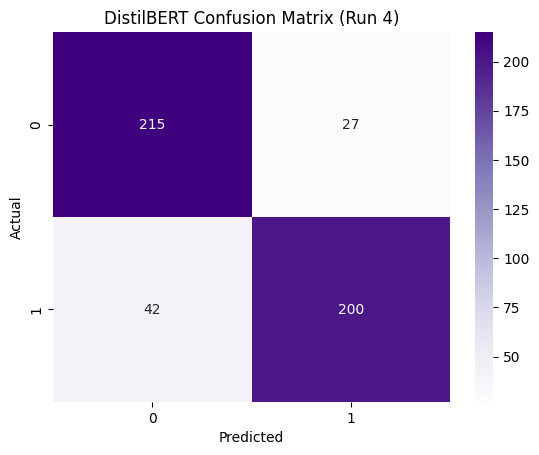

In [13]:
########## 5. Confusion Matrix for DistilBERT ##########
accuracies.append(accuracy_score(labels, preds))
precisions.append(precision_score(labels, preds))
recalls.append(recall_score(labels, preds))
f1_scores.append(f1_score(labels, preds))
losses.append(log_loss(labels, proba))
print(f"DistilBERT Classification Report (Run {seed}):")
print(classification_report(labels, preds, digits=4))

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Purples')
plt.title(f"DistilBERT Confusion Matrix (Run {seed})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()